In [1]:
!git clone https://github.com/ElanaPearl/interPLM.git
%cd interPLM
!pip install -e .
!pip install biopython

Cloning into 'interPLM'...
remote: Enumerating objects: 269, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 269 (delta 59), reused 147 (delta 56), pack-reused 94 (from 1)
Receiving objects: 100% (269/269), 242.93 KiB | 9.34 MiB/s, done.
Resolving deltas: 100% (105/105), done.
/content/interPLM
Obtaining file:///content/interPLM
  Preparing metadata (setup.py) ... done
  Running setup.py develop for interplm
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 53.9 MB/s eta 0:00:00


## Pobieranie danych

## Zbiór Danych: CATH Protein Domains


W bazie CATH istnieje ścisła hierarchia.

| Poziom | Oznaczenie | Nazwa | Liczba Klas* |
| --- | --- | --- | --- |
| **C** | `1` | **Class** | 5 |
| **A** | `1.10` | **Architecture** | 26 |
| **T** | `1.10.8` | **Topology** | 520  |
| **H** | `1.10.8.10` | **Homology** | 671 |

**Liczby klas są przybliżone i zależą od wersji bazy CATH.*

Będziemy trenować model na poziomie C.A.T, ponieważ niższe poziomy są zbyt ogólne, a poziom C.A.T.H jest zbyt rozdrobniony.


In [2]:
%%bash
mkdir -p cath_data
cd cath_data

echo "Pobieranie etykiet..."
wget -q -nc ftp://orengoftp.biochem.ucl.ac.uk/cath/releases/latest-release/cath-classification-data/cath-domain-list.txt

echo "Pobieranie sekwencji..."
wget -q -nc ftp://orengoftp.biochem.ucl.ac.uk/cath/releases/latest-release/sequence-data/cath-domain-seqs.fa
ls -lh

Pobieranie etykiet...
Pobieranie sekwencji...
total 154M
-rw-r--r-- 1 root root  43M Jan 22 13:24 cath-domain-list.txt
-rw-r--r-- 1 root root 112M Jan 22 13:24 cath-domain-seqs.fa


In [3]:
!head -20 cath_data/cath-domain-list.txt

#---------------------------------------------------------------------
# FILE NAME:    CathDomainList.v4.4.0
# FILE DATE:    16.12.2024
#
# CATH VERSION: v4.4.0
# VERSION DATE: 16.12.2024
#
# FILE FORMAT:  Cath List File (CLF) Format 2.0
#
# FILE DESCRIPTION:
# Contains all classified protein domains in CATH
# for class 1 (mainly alpha), class 2 (mainly beta),
# class 3 (alpha and beta) and class 4 (few secondary structures).
#
# See 'README.file_formats' for file format information
#---------------------------------------------------------------------
1oaiA00     1    10     8    10     1     1     1     1     1    59 1.000
1go5A00     1    10     8    10     1     1     1     1     2    69 999.000
3frhA01     1    10     8    10     2     1     1     1     1    58 1.200
3friA01     1    10     8    10     2     1     1     1     2    54 1.800


# Preprocessing danych
Poniżej wczytujemy dane i przygotujemy je do trenowania modeli ML. Pierwszym etapem jest wczytanie danych z plików `cath-domain-list.txt`. Plik `cath-domain-list.txt` zawiera informacje o domenach białkowych, w tym ich klasyfikację w hierarchii CATH. Plik `cath-domain-seqs.fa` zawiera sekwencje aminokwasowe tych domen.

In [4]:
LABEL_FILE = 'cath_data/cath-domain-list.txt'
SEQ_FILE = 'cath_data/cath-domain-seqs.fa'
column_names = [
    'domain_id', 'class_C', 'arch_A', 'top_T', 'hom_H',
    's35', 's60', 's95', 's100', 's100_count', 'domain_len', 'resolution'
]

In [5]:
import pandas as pd
df_labels = pd.read_csv(
    LABEL_FILE,
    sep=r'\s+',
    comment='#',
    header=None,
    names=column_names,
    usecols=['domain_id', 'class_C', 'arch_A', 'top_T', 'hom_H']
)

print(df_labels[['class_C', 'arch_A', 'top_T', 'hom_H']].nunique())
print("Rozkład klas (C):")
print(df_labels['class_C'].value_counts())

top_families = df_labels['hom_H'].value_counts()
print("\nTop 5 najliczniejszych rodzin:")
print(top_families.head(5))

print("\n5 najmniej licznych rodzin:")
print(top_families.tail(5))

max_share = (top_families.iloc[0] / len(df_labels)) * 100
print(f"\nNajwiększa rodzina stanowi {max_share:.2f}% całego zbioru.")

class_C      5
arch_A      26
top_T      520
hom_H      671
dtype: int64
Rozkład klas (C):
class_C
3    305361
2    158943
1    126178
4      6034
6      4812
Name: count, dtype: int64

Top 5 najliczniejszych rodzin:
hom_H
10     318000
20      42817
30      14369
300     14214
720     13828
Name: count, dtype: int64

5 najmniej licznych rodzin:
hom_H
11620    1
11630    1
11530    1
11960    1
12140    1
Name: count, dtype: int64

Największa rodzina stanowi 52.88% całego zbioru.


Łączymy poziomy C, A, T w jeden etykietę klasyfikacyjną w formacie `C.A.T`, np. `1.10.8`. Następnie wczytujemy plik `cath-domain-seqs.fa`, który zawiera sekwencje aminokwasowe domen białkowych. Tworzymy słownik mapujący identyfikatory domen na ich sekwencje. Następnie łączymy te dane, aby uzyskać ostateczny DataFrame zawierający identyfikatory domen, etykiety klasyfikacyjne, oraz odpowiadające im sekwencje.

In [6]:

from Bio import SeqIO


df_labels['target_label'] = (
    df_labels['class_C'].astype(str) + "." +
    df_labels['arch_A'].astype(str) + "." +
    df_labels['top_T'].astype(str)
)
df_labels.drop(columns=['class_C', 'arch_A', 'top_T', 'hom_H'], inplace=True, errors='ignore')


print(f"Wczytywanie sekwencji z {SEQ_FILE}")
seq_data = []

with open(SEQ_FILE, "r") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        original_id = record.id
        # original_id = cath|4_4_0|3avrA01/886-901_1246-1312_1380-1395
        try:
            part_with_id = original_id.split('|')[2]
            # part_with_id = 3avrA01/886-901_1246-1312_1380-1395

            clean_id = part_with_id.split('/')[0]
            # clean_id = 3avrA01
            seq_data.append({
                'domain_id': clean_id,
                'sequence': str(record.seq)
            })
        except IndexError:
            print(f"Pominięto nietypowy nagłówek: {original_id}")
            continue

df_seqs = pd.DataFrame(seq_data)


print("Łączenie sekwencji z etykietami")
full_dataset = pd.merge(df_labels, df_seqs, on='domain_id', how='inner')

print("-" * 50)
print(f"GOTOWY ZBIÓR DANYCH: {len(full_dataset)} próbek.")
print("-" * 50)
pd.set_option('display.max_colwidth', 50)
print(full_dataset.head())

Wczytywanie sekwencji z cath_data/cath-domain-seqs.fa
Łączenie sekwencji z etykietami
--------------------------------------------------
GOTOWY ZBIÓR DANYCH: 601328 próbek.
--------------------------------------------------
  domain_id target_label                                           sequence
0   1oaiA00       1.10.8  PTLSPEQQEMLQAFSTQSGMNLEWSQKCLQDNNWDYTRSAQAFTHL...
1   1go5A00       1.10.8  PAPTPSSSPVPTLSPEQQEMLQAFSTQSGMNLEWSQKCLQDNNWDY...
2   3frhA01       1.10.8  YPMNINDALTSILASKKYRALCPDTVRRILTEEWGRHKSPKQTVEA...
3   3friA01       1.10.8  YPMNINDALTSILASKKYRALCPDTVRRILTEEWGRHKSPKQTVEA...
4   3b89A01       1.10.8  SLNINDALTSILASKKYRALCPDTVRRILTEEWGRHKSPKQTVEAA...


Wyświetlamy wykres najczęstszych klas w zbiorze danych, aby zobaczyć rozkład etykiet.

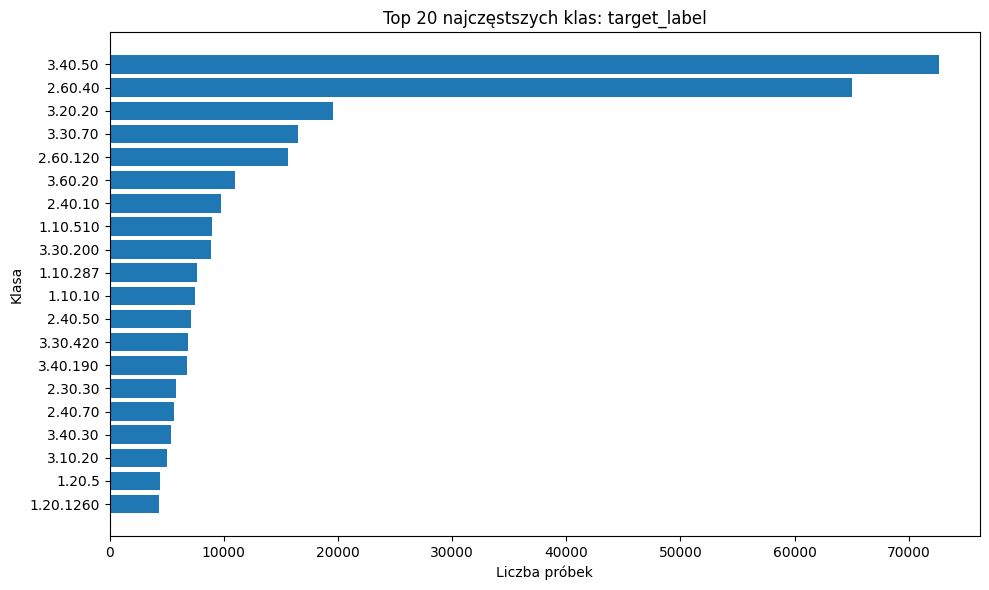

In [7]:
import matplotlib.pyplot as plt

# Rozkład najczęstszych klas:
label_col = 'target_label'

top_n = 20
vc = full_dataset[label_col].value_counts().head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(vc.index.astype(str)[::-1], vc.values[::-1])
plt.xlabel('Liczba próbek')
plt.ylabel('Klasa')
plt.title(f'Top {top_n} najczęstszych klas: {label_col}')
plt.tight_layout()
plt.show()

# Wykorzystanie InterPLM do ekstrakcji cech
Wykorzystujemy model `InterPLM` do ekstrakcji cech z sekwencji aminokwasowych. Model ten jest wstępnie wytrenowany na dużym zbiorze danych białkowych i potrafi generować reprezentacje wektorowe (embeddingi) dla sekwencji białkowych. Te embeddingi będą następnie użyte jako cechy wejściowe do modeli klasyfikacyjnych. Wykorzystujemy model białkowy `ESM2-8M-UR50D`.

In [8]:
import torch
from transformers import AutoModel, AutoTokenizer
from interplm.sae.inference import load_sae_from_hf

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używam urządzenia: {DEVICE}")

MODEL_NAME = "esm2-8m"
HF_MODEL_NAME = "facebook/esm2_t6_8M_UR50D"
LAYER_ID = 6

print("Ładowanie modelu ESM-2")
tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME)
base_model = AutoModel.from_pretrained(HF_MODEL_NAME).to(DEVICE)
base_model.eval()

print(f"Ładowanie SAE dla warstwy {LAYER_ID}...")
sae = load_sae_from_hf(plm_model=MODEL_NAME, plm_layer=LAYER_ID)
sae = sae.to(DEVICE)
sae.eval()


Używam urządzenia: cuda
Ładowanie modelu ESM-2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ładowanie SAE dla warstwy 6...


layer_6/ae_normalized.pt:   0%|          | 0.00/26.3M [00:00<?, ?B/s]

Loading configs from /root/.cache/huggingface/hub/models--Elana--InterPLM-esm2-8m/snapshots/81d2429cd9dae7175f1dcd8b4c649a20cdc06c8c/layer_6/config.yaml
Loaded data type: <class 'interplm.train.configs.TrainingRunConfig'>
Data keys: Not a dict


ReLUSAE(
  (encoder): Linear(in_features=320, out_features=10240, bias=True)
  (decoder): Linear(in_features=10240, out_features=320, bias=False)
)

Ponieważ zbiór danych jest duży to niestety wyekstrahowane cechy nie mieszczą się w pamięci RAM. Dlatego ekstrakcję cech ograniczamy do podzbioru danych. Wynikiem funckji `extract_interplm_features` jest macierz cech `X` zawierający embeddingi.

In [9]:
import numpy as np
from tqdm import tqdm

# --- OGRANICZENIE DANYCH ---
SAMPLE_SIZE = 50_000

if SAMPLE_SIZE:
    df_subset = full_dataset.sample(n=min(SAMPLE_SIZE, len(full_dataset)), random_state=42).copy()
else:
    df_subset = full_dataset.copy()

print(f"Przetwarzanie {len(df_subset)} próbek...")

def extract_sae_features(sequences, batch_size=32):
    all_features = []

    for i in tqdm(range(0, len(sequences), batch_size)):
        batch_seqs = sequences[i:i+batch_size]

        inputs = tokenizer(
            batch_seqs,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(DEVICE)

        with torch.no_grad():
            # Przepuszczamy sekwencje przez ESM-2
            outputs = base_model(**inputs, output_hidden_states=True)

            # Pobieramy hidden state z wybranej warstwy
            dense_acts = outputs.hidden_states[LAYER_ID]

            # Przepuszczamy pobraną warstwe InterPLM
            sae_acts = sae.encode(dense_acts)

            # SAE zwraca osobne cechy dla każdego aminokwasu
            # uśredniamy, aby uzyskać jeden wektor opisujący całe białko dla klasyfikatora.
            mask = inputs['attention_mask'].unsqueeze(-1).float()
            sum_features = torch.sum(sae_acts * mask, dim=1)
            count_tokens = torch.clamp(mask.sum(dim=1), min=1e-9)
            mean_features = sum_features / count_tokens

            all_features.append(mean_features.cpu().numpy())

    return np.vstack(all_features)

X = extract_sae_features(df_subset['sequence'].tolist())
y = df_subset['target_label'].values

print(f"\nWymiary macierzy cech X: {X.shape}")
print(f"Liczba etykiet y: {len(y)}")

Przetwarzanie 50000 próbek...


100%|██████████| 1563/1563 [04:50<00:00,  5.37it/s]



Wymiary macierzy cech X: (50000, 10240)
Liczba etykiet y: 50000


W zbiorze danych mogą występować klasy z jedną próbką, które nie mogą być użyte do trenowania lub ewaluacji modeli. Usuwamy te klasy z danych przed podziałem na zbiór treningowy i testowy. Następnie dzielimy dane na zbiór treningowy i testowy, zachowując proporcje klas za pomocą stratifikacji. Na końcu konwertujemy dane na tensory PyTorch, aby umożliwić trenowanie modeli na GPU.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Wspólny słownik na metryki (zbierany z różnych modeli)
results = globals().get('results', {})

# Usuwamy klasy z jedną próbką (nie można ich użyć do trenowania/ewaluacji)
unique_classes, counts = np.unique(y, return_counts=True)
valid_classes = unique_classes[counts > 1]
mask_valid = np.isin(y, valid_classes)
X_filtered = X[mask_valid]
y_filtered = y[mask_valid]

le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Trenowanie na: {DEVICE}")

# Konwersja danych na tensory PyTorch
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(DEVICE)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)

input_dim = X_train.shape[1]
output_dim = len(valid_classes)


Trenowanie na: cuda


Definiujemy pomocniczą funkcję `show_confususion_and_top_mistakes` do wyświetlania macierzy pomyłek oraz najczęstszych błędów klasyfikacji dla modeli ML. Funkcja ta przyjmuje jako argumenty model, dane testowe oraz etykiety prawdziwe. Po przewidzeniu etykiet przez model, funkcja generuje i wyświetla macierz pomyłek oraz listę najczęstszych błędów klasyfikacji, co pomaga w analizie wydajności modelu.

In [11]:
def show_confusion_and_top_mistakes(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    label_encoder: LabelEncoder,
    title: str,
    top_k: int = 10,
    max_classes: int = 30,
):
    class_names = np.asarray(label_encoder.classes_)
    n_classes = len(class_names)

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))

    # Top-K pomyłek (poza przekątną)
    cm_off = cm.copy()
    np.fill_diagonal(cm_off, 0)

    flat = cm_off.ravel()
    rows = []
    for idx in np.argsort(flat)[::-1]:
        cnt = int(flat[idx])
        if cnt <= 0:
            break
        i = idx // n_classes
        j = idx % n_classes
        rows.append({
            'true_label': str(class_names[i]),
            'pred_label': str(class_names[j]),
            'count': cnt,
        })
        if len(rows) >= top_k:
            break

    print(f"\n{title} — TOP {top_k} najczęściej mylonych (true → pred)")
    display(pd.DataFrame(rows))

    # Confusion matrix (gdy klas jest dużo, pokazujemy top-N po częstości w y_true)
    if n_classes > max_classes:
        support = np.bincount(y_true, minlength=n_classes)
        top_idx = np.argsort(support)[::-1][:max_classes]
        top_idx = np.sort(top_idx)
        cm_plot = cm[np.ix_(top_idx, top_idx)]
        labels_plot = class_names[top_idx]
        title_plot = f"{title} — confusion matrix (top {max_classes} klas)"
    else:
        cm_plot = cm
        labels_plot = class_names
        title_plot = f"{title} — confusion matrix"

    fig_size = max(8, int(0.35 * len(labels_plot) + 4))
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    ConfusionMatrixDisplay(confusion_matrix=cm_plot, display_labels=labels_plot).plot(
        ax=ax,
        xticks_rotation=90,
        cmap='Blues',
        colorbar=False,
        values_format='d',
    )
    ax.set_title(title_plot)
    plt.tight_layout()
    plt.show()

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    )
import numpy as np
import pandas as pd

def report_metrics_by_cath_levels(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    label_encoder: LabelEncoder,
    title: str,
    top_k: int = 10,
    max_classes: int = 30,
    include_confusion: bool = True,
    ):
    """Raportuje metryki na poziomach C, C.A i C.A.T dla predykcji CAT."""
    y_true_cat = label_encoder.inverse_transform(np.asarray(y_true))
    y_pred_cat = label_encoder.inverse_transform(np.asarray(y_pred))

    def split_cat(label: str):
        parts = str(label).split(".")
        if len(parts) < 3:
            parts = (parts + ["", ""])[:3]
        return parts[0], parts[1], parts[2]

    c_true, a_true, t_true = zip(*(split_cat(x) for x in y_true_cat))
    c_pred, a_pred, t_pred = zip(*(split_cat(x) for x in y_pred_cat))

    levels = {
        "C": (np.asarray(c_true), np.asarray(c_pred)),
        "C.A": (np.asarray([f"{c}.{a}" for c, a in zip(c_true, a_true)]),
                np.asarray([f"{c}.{a}" for c, a in zip(c_pred, a_pred)])),
        "C.A.T": (np.asarray(y_true_cat), np.asarray(y_pred_cat)),
    }

    rows = []
    for level_name, (yt, yp) in levels.items():
        acc = accuracy_score(yt, yp)
        f1 = f1_score(yt, yp, average="macro", zero_division=0)
        p = precision_score(yt, yp, average="macro", zero_division=0)
        r = recall_score(yt, yp, average="macro", zero_division=0)
        rows.append({
            "level": level_name,
            "accuracy": acc,
            "f1_macro": f1,
            "precision_macro": p,
            "recall_macro": r,
        })

        print("\n" + "=" * 80)
        print(f"{title} — metryki na poziomie {level_name}")
        print("-" * 80)
        print(f"Accuracy:  {acc:.2%}")
        print(f"F1 macro:  {f1:.2%}")
        print(f"Precision: {p:.2%}")
        print(f"Recall:    {r:.2%}")
        print("-" * 80)
        labels_sorted = np.unique(yt)
        print(classification_report(yt, yp, labels=labels_sorted, zero_division=0))

        if include_confusion:
            le_lvl = LabelEncoder()
            le_lvl.fit(np.concatenate([yt, yp]))
            yt_enc = le_lvl.transform(yt)
            yp_enc = le_lvl.transform(yp)
            show_confusion_and_top_mistakes(
                y_true=yt_enc,
                y_pred=yp_enc,
                label_encoder=le_lvl,
                title=f"{title} ({level_name})",
                top_k=top_k,
                max_classes=max_classes,
            )

    df_levels = pd.DataFrame(rows).set_index("level")
    return df_levels

## Trening na GPU.


Zdecydowaliśmy się wytrenować dwa modele klasyfikacyjne: Logistic Regression oraz Multi-Layer Perceptron (MLP). Oba modele zostaną wytrenowane na wyekstrahowanych cechach z modelu InterPLM. Dla każdego modelu przeprowadzimy trening, a następnie ocenimy jego wydajność na zbiorze testowym, wykorzystując różne metryki klasyfikacji, takie jak dokładność (accuracy), precyzja (precision), recall oraz F1-score. Wyniki zostaną zapisane w słowniku `results` dla późniejszej analizy i porównania między modelami.

### Logistic Regression

Zaimplementowaliśmy ją jako SLP (single layer perception) z wykorzystaniem biblioteki pytorch. Pozwala to na uruchomienie na GPU co znacznie przyśpieszyło trening modelu.

Epoch [1/1000], Loss: 6.8044
Epoch [100/1000], Loss: 1.6509
Epoch [200/1000], Loss: 0.9851
Epoch [300/1000], Loss: 0.7112
Epoch [400/1000], Loss: 0.5564
Epoch [500/1000], Loss: 0.4558
Epoch [600/1000], Loss: 0.3847
Epoch [700/1000], Loss: 0.3317
Epoch [800/1000], Loss: 0.2906
Epoch [900/1000], Loss: 0.2579
Epoch [1000/1000], Loss: 0.2312
Ewaluacja
------------------------------
Accuracy:       89.49%
F1:       79.13%
Precision: 82.84%
Recall:    77.44%
------------------------------
              precision    recall  f1-score   support

     1.10.10       0.76      0.78      0.77       120
    1.10.100       1.00      1.00      1.00         1
   1.10.1020       1.00      1.00      1.00         1
   1.10.1030       1.00      1.00      1.00         1
   1.10.1040       0.78      0.78      0.78         9
   1.10.1050       1.00      1.00      1.00         6
   1.10.1060       1.00      1.00      1.00         3
   1.10.1070       1.00      1.00      1.00         4
   1.10.1090       1.00  

,true_label,pred_label,count
0,2.60.120,2.60.40,19
1,2.60.40,2.60.120,15
2,3.30.70,3.40.50,13
3,3.10.20,3.30.70,11
4,3.30.420,3.40.50,9
5,3.90.1150,3.40.50,8
6,1.10.10,1.10.8,8
7,3.40.50,3.30.70,7
8,3.30.300,3.30.70,7
9,3.40.190,3.40.50,6


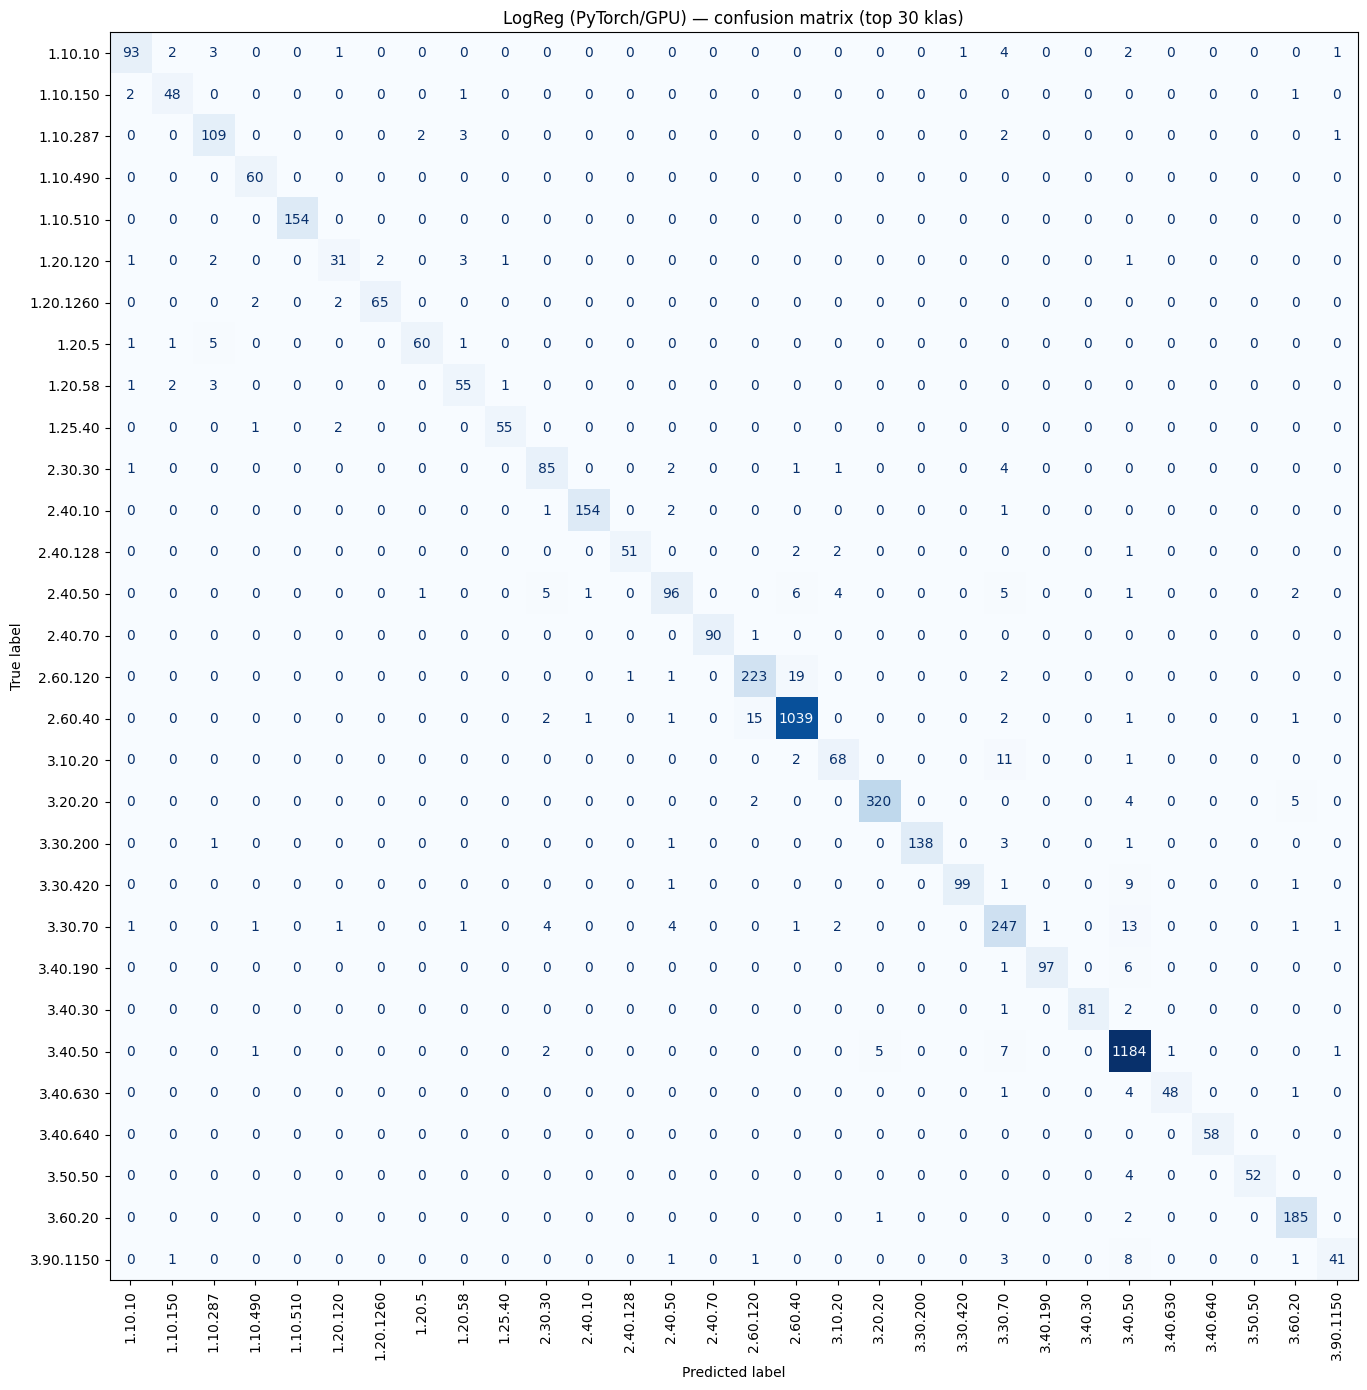


LogReg (PyTorch/GPU) — metryki na poziomie C
--------------------------------------------------------------------------------
Accuracy:  97.15%
F1 macro:  90.45%
Precision: 92.97%
Recall:    88.32%
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.97      0.97      0.97      2062
           2       0.97      0.97      0.97      2620
           3       0.98      0.98      0.98      5095
           4       0.97      0.86      0.91       109
           6       0.77      0.63      0.69        73

    accuracy                           0.97      9959
   macro avg       0.93      0.88      0.90      9959
weighted avg       0.97      0.97      0.97      9959


LogReg (PyTorch/GPU) (C) — TOP 10 najczęściej mylonych (true → pred)


,true_label,pred_label,count
0,3,2,74
1,2,3,58
2,1,3,49
3,3,1,38
4,6,1,22
5,1,6,9
6,4,3,6
7,2,1,6
8,4,1,5
9,3,6,4


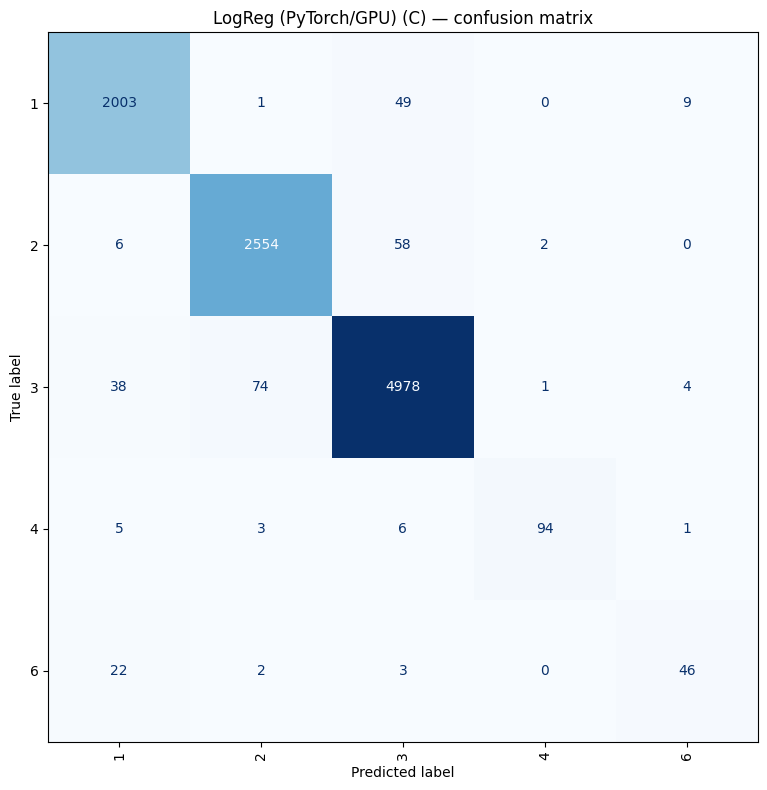


LogReg (PyTorch/GPU) — metryki na poziomie C.A
--------------------------------------------------------------------------------
Accuracy:  92.82%
F1 macro:  92.10%
Precision: 94.48%
Recall:    90.58%
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

        1.10       0.93      0.94      0.94      1361
        1.20       0.90      0.90      0.90       598
        1.25       0.89      0.93      0.91        84
        1.50       1.00      0.79      0.88        19
        2.10       0.89      0.91      0.90        82
       2.100       1.00      0.86      0.92         7
       2.102       1.00      1.00      1.00         8
       2.110       1.00      1.00      1.00         1
       2.115       1.00      0.92      0.96        12
       2.120       0.92      1.00      0.96        22
       2.130       1.00      0.98      0.99        50
       2.140       1.00      1.00      1.00        11
       2.150   

,true_label,pred_label,count
0,3.30,3.40,65
1,1.20,1.10,45
2,3.40,3.30,28
3,1.10,1.20,25
4,3.90,3.40,24
5,3.90,3.30,24
6,3.10,3.30,24
7,1.10,3.30,19
8,3.30,1.10,18
9,2.40,2.60,17


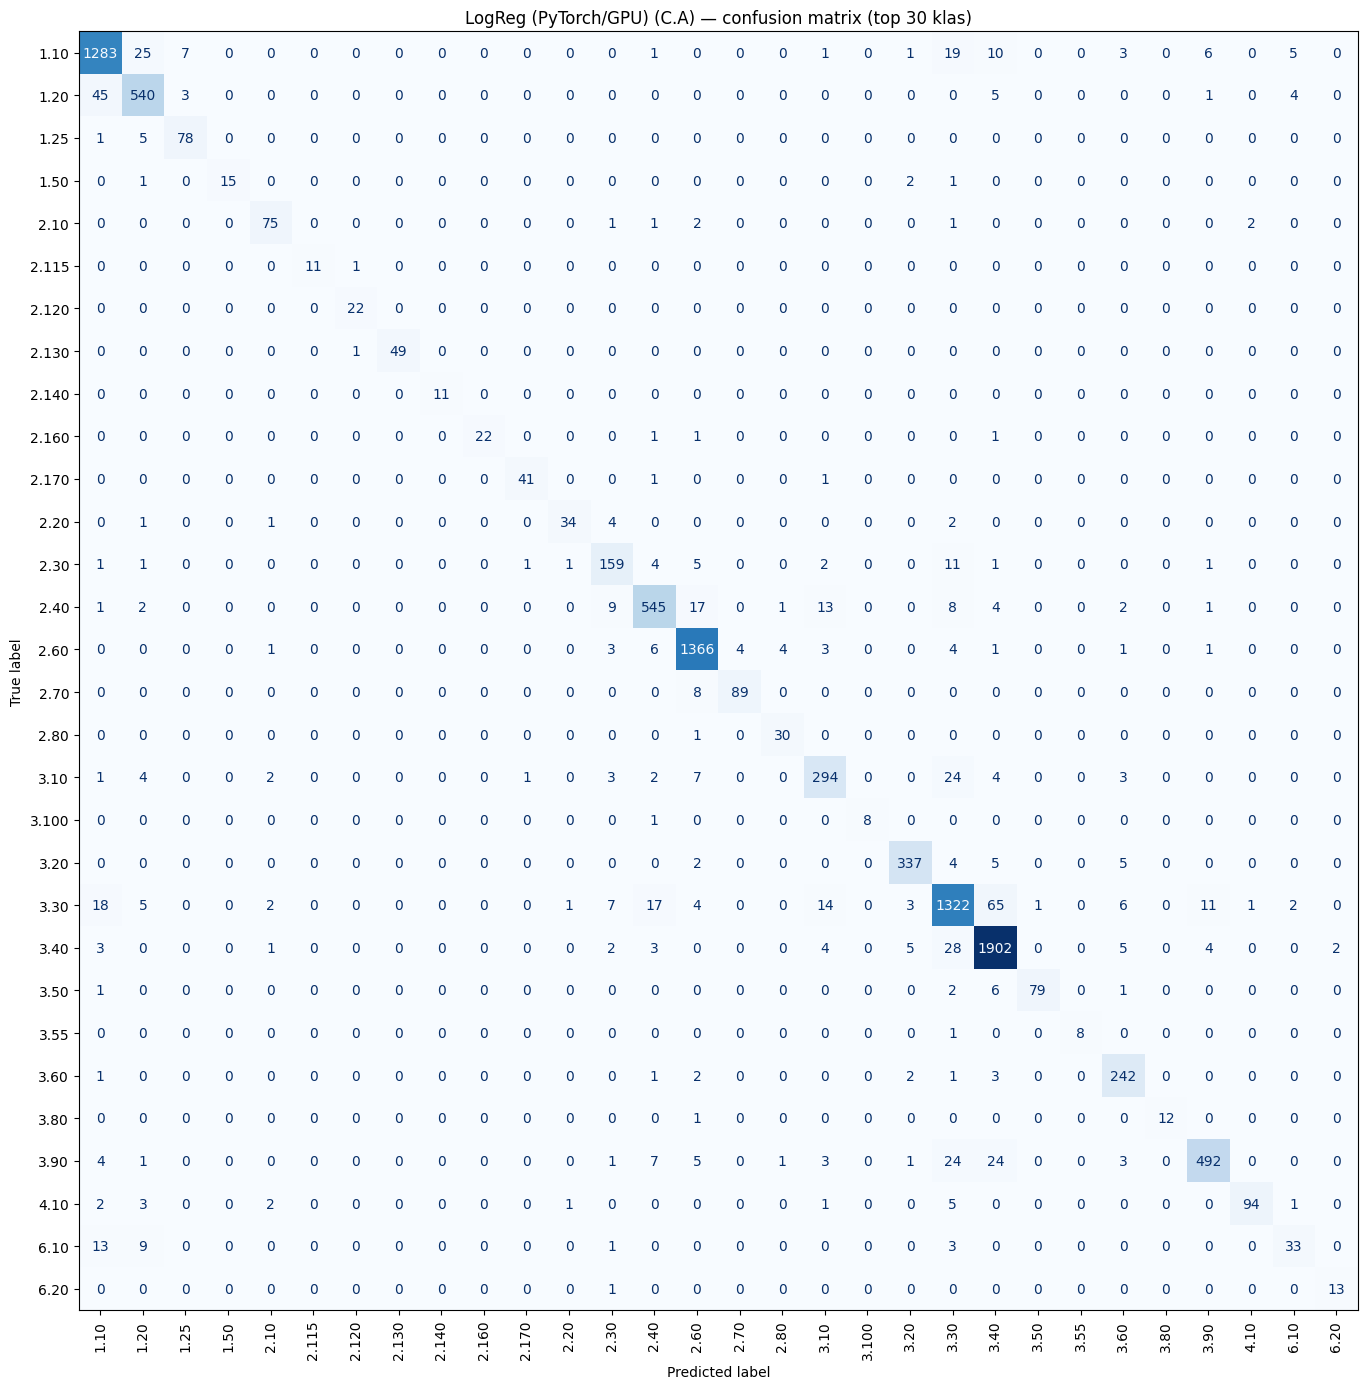


LogReg (PyTorch/GPU) — metryki na poziomie C.A.T
--------------------------------------------------------------------------------
Accuracy:  89.49%
F1 macro:  79.13%
Precision: 82.84%
Recall:    77.44%
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

     1.10.10       0.76      0.78      0.77       120
    1.10.100       1.00      1.00      1.00         1
   1.10.1020       1.00      1.00      1.00         1
   1.10.1030       1.00      1.00      1.00         1
   1.10.1040       0.78      0.78      0.78         9
   1.10.1050       1.00      1.00      1.00         6
   1.10.1060       1.00      1.00      1.00         3
   1.10.1070       1.00      1.00      1.00         4
   1.10.1090       1.00      1.00      1.00         1
    1.10.110       0.00      0.00      0.00         1
   1.10.1130       0.75      1.00      0.86         3
   1.10.1140       1.00      1.00      1.00         8
   1.10.1160 

,true_label,pred_label,count
0,2.60.120,2.60.40,19
1,2.60.40,2.60.120,15
2,3.30.70,3.40.50,13
3,3.10.20,3.30.70,11
4,3.30.420,3.40.50,9
5,3.90.1150,3.40.50,8
6,1.10.10,1.10.8,8
7,3.30.300,3.30.70,7
8,3.40.50,3.30.70,7
9,3.40.190,3.40.50,6


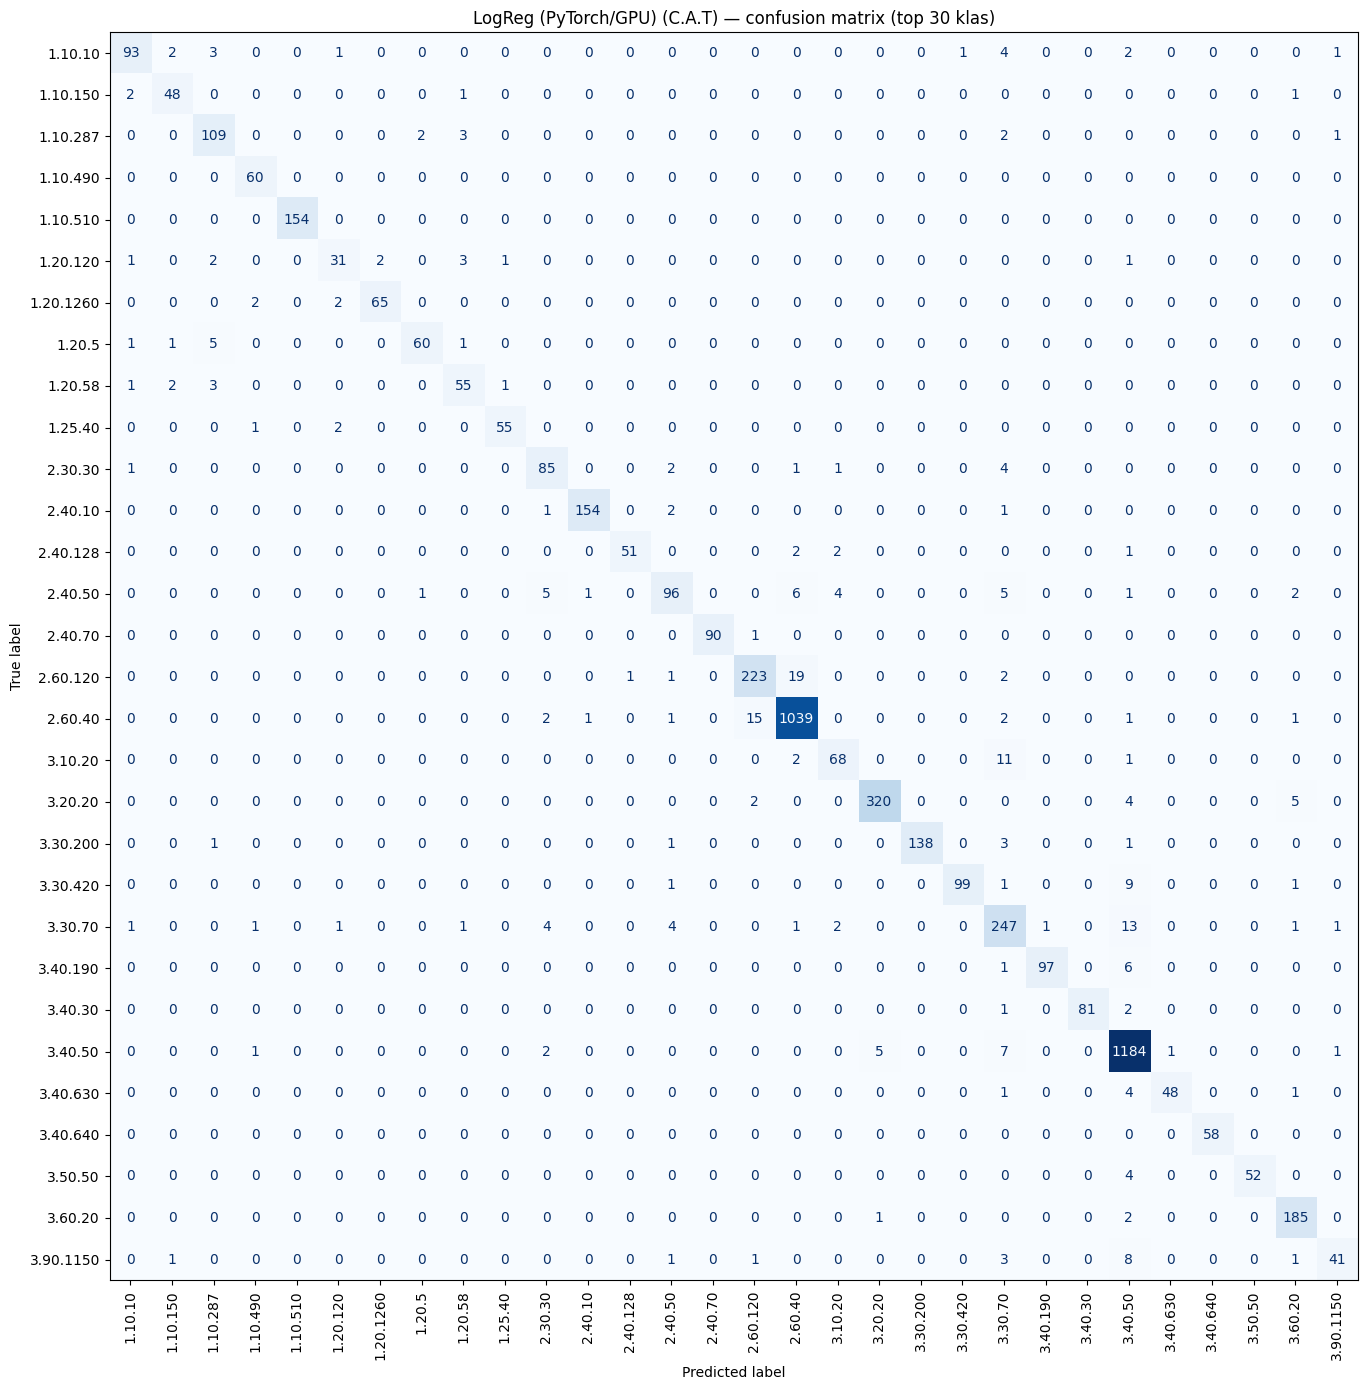

,accuracy,f1_macro,precision_macro,recall_macro
level,,,,
C,0.971483,0.904453,0.929672,0.883151
C.A,0.928206,0.921017,0.944768,0.905822
C.A.T,0.894869,0.791255,0.828411,0.774353


In [13]:

class LogisticRegressionPyTorch(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionPyTorch, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

model = LogisticRegressionPyTorch(input_dim, output_dim).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
EPOCHS = 1000

loss_history = []

for epoch in range(EPOCHS):
    model.train()

    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss_history.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

print("Ewaluacja")
model.eval()
with torch.no_grad():
    outputs = model(X_test_t)
    _, predicted = torch.max(outputs.data, 1)
    y_pred = predicted.cpu().numpy()

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
p = precision_score(y_test, y_pred, average='macro', zero_division=0)
r = recall_score(y_test, y_pred, average='macro', zero_division=0)

# Zapis metryk do porównania
results['LogReg (PyTorch/GPU)'] = {
    'accuracy': acc,
    'f1_macro': f1,
    'precision_macro': p,
    'recall_macro': r,
}
globals()['results'] = results

print("-" * 30)
print(f"Accuracy:       {acc:.2%}")
print(f"F1:       {f1:.2%}")
print(f"Precision: {p:.2%}")
print(f"Recall:    {r:.2%}")
print("-" * 30)

unique_test_labels = np.unique(y_test)
target_names = le.inverse_transform(unique_test_labels)

print(classification_report(
    y_test,
    y_pred,
    labels=unique_test_labels,
    target_names=target_names,
    zero_division=0
) )

# Confusion matrix + TOP-10 pomyłek
show_confusion_and_top_mistakes(
    y_true=y_test,
    y_pred=y_pred,
    label_encoder=le,
    title='LogReg (PyTorch/GPU)',
    top_k=10,
    max_classes=30,
)

# Metryki na poziomach C / C.A / C.A.T
df_levels = report_metrics_by_cath_levels(
    y_true=y_test,
    y_pred=y_pred,
    label_encoder=le,
    title='LogReg (PyTorch/GPU)',
    top_k=10,
    max_classes=30,
)
results_levels = globals().get('results_levels', {})
results_levels['LogReg (PyTorch/GPU)'] = df_levels
globals()['results_levels'] = results_levels
display(df_levels)

In [14]:
# Wyświetl kilka przykładowych predykcji
n_examples = 10
sample_indices = np.random.choice(len(y_test), size=min(n_examples, len(y_test)), replace=False)

print("Przykładowe predykcje:")
print("-" * 80)
print(f"{'True Label':<20} {'Predicted Label':<20} {'Correct':<10}")
print("-" * 80)

for idx in sample_indices:
    true_label = le.inverse_transform([y_test[idx]])[0]
    pred_label = le.inverse_transform([y_pred[idx]])[0]
    is_correct = "✓" if y_test[idx] == y_pred[idx] else "✗"

    print(f"{true_label:<20} {pred_label:<20} {is_correct:<10}")

print("-" * 80)

Przykładowe predykcje:
--------------------------------------------------------------------------------
True Label           Predicted Label      Correct   
--------------------------------------------------------------------------------
3.30.1390            3.30.1390            ✓         
2.70.170             2.70.170             ✓         
2.60.120             2.60.40              ✗         
3.40.309             3.40.309             ✓         
3.20.10              3.20.10              ✓         
3.30.2090            3.30.2090            ✓         
2.60.40              2.60.40              ✓         
3.60.20              3.60.20              ✓         
3.40.430             3.40.430             ✓         
1.10.3270            1.10.3270            ✓         
--------------------------------------------------------------------------------


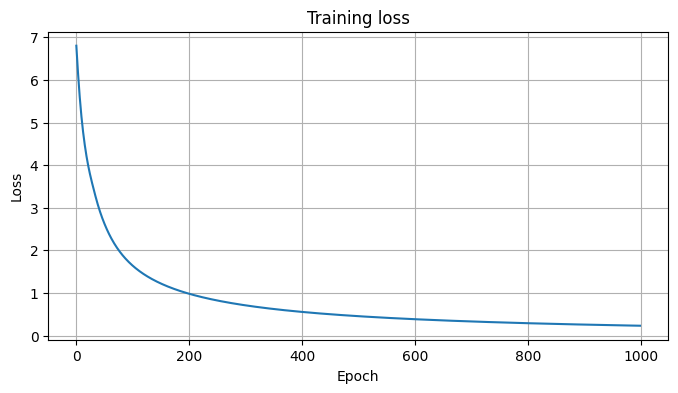

In [15]:
# Wykres loss
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.grid(True)
plt.show()

### Deep Neural Network (MLP)

Podobnie jak w przypadku SLP również tutaj wykorzystano  bibliotekę pytorch. MLP składa się z warstwy wejściowej o rozmiarze równym liczbie cech, dwóch warstw ukrytych o 32 neuronach i warstwy wyjściowej o rozmiarze równym liczbie klas.

Epoch [1/1000], Loss: 6.8094
Epoch [100/1000], Loss: 0.9829
Epoch [200/1000], Loss: 0.4627
Epoch [300/1000], Loss: 0.2636
Epoch [400/1000], Loss: 0.1575
Epoch [500/1000], Loss: 0.0942
Epoch [600/1000], Loss: 0.0606
Epoch [700/1000], Loss: 0.0423
Epoch [800/1000], Loss: 0.0315
Epoch [900/1000], Loss: 0.0249
Epoch [1000/1000], Loss: 0.0205
Ewaluacja
------------------------------
Accuracy:       91.38%
F1:       78.07%
Precision: 80.82%
Recall:    77.68%
------------------------------
              precision    recall  f1-score   support

     1.10.10       0.76      0.89      0.82       120
    1.10.100       1.00      1.00      1.00         1
   1.10.1020       1.00      1.00      1.00         1
   1.10.1030       1.00      1.00      1.00         1
   1.10.1040       0.62      0.56      0.59         9
   1.10.1050       1.00      1.00      1.00         6
   1.10.1060       1.00      1.00      1.00         3
   1.10.1070       1.00      1.00      1.00         4
   1.10.1090       1.00  

,true_label,pred_label,count
0,2.60.120,2.60.40,9
1,2.60.40,2.60.120,9
2,1.20.5,1.10.287,6
3,3.40.50,3.20.20,6
4,3.30.300,3.30.70,6
5,3.90.1150,3.40.50,5
6,1.10.10,1.10.8,5
7,2.40.30,2.40.50,5
8,2.40.50,2.30.30,4
9,3.40.50,3.30.70,4


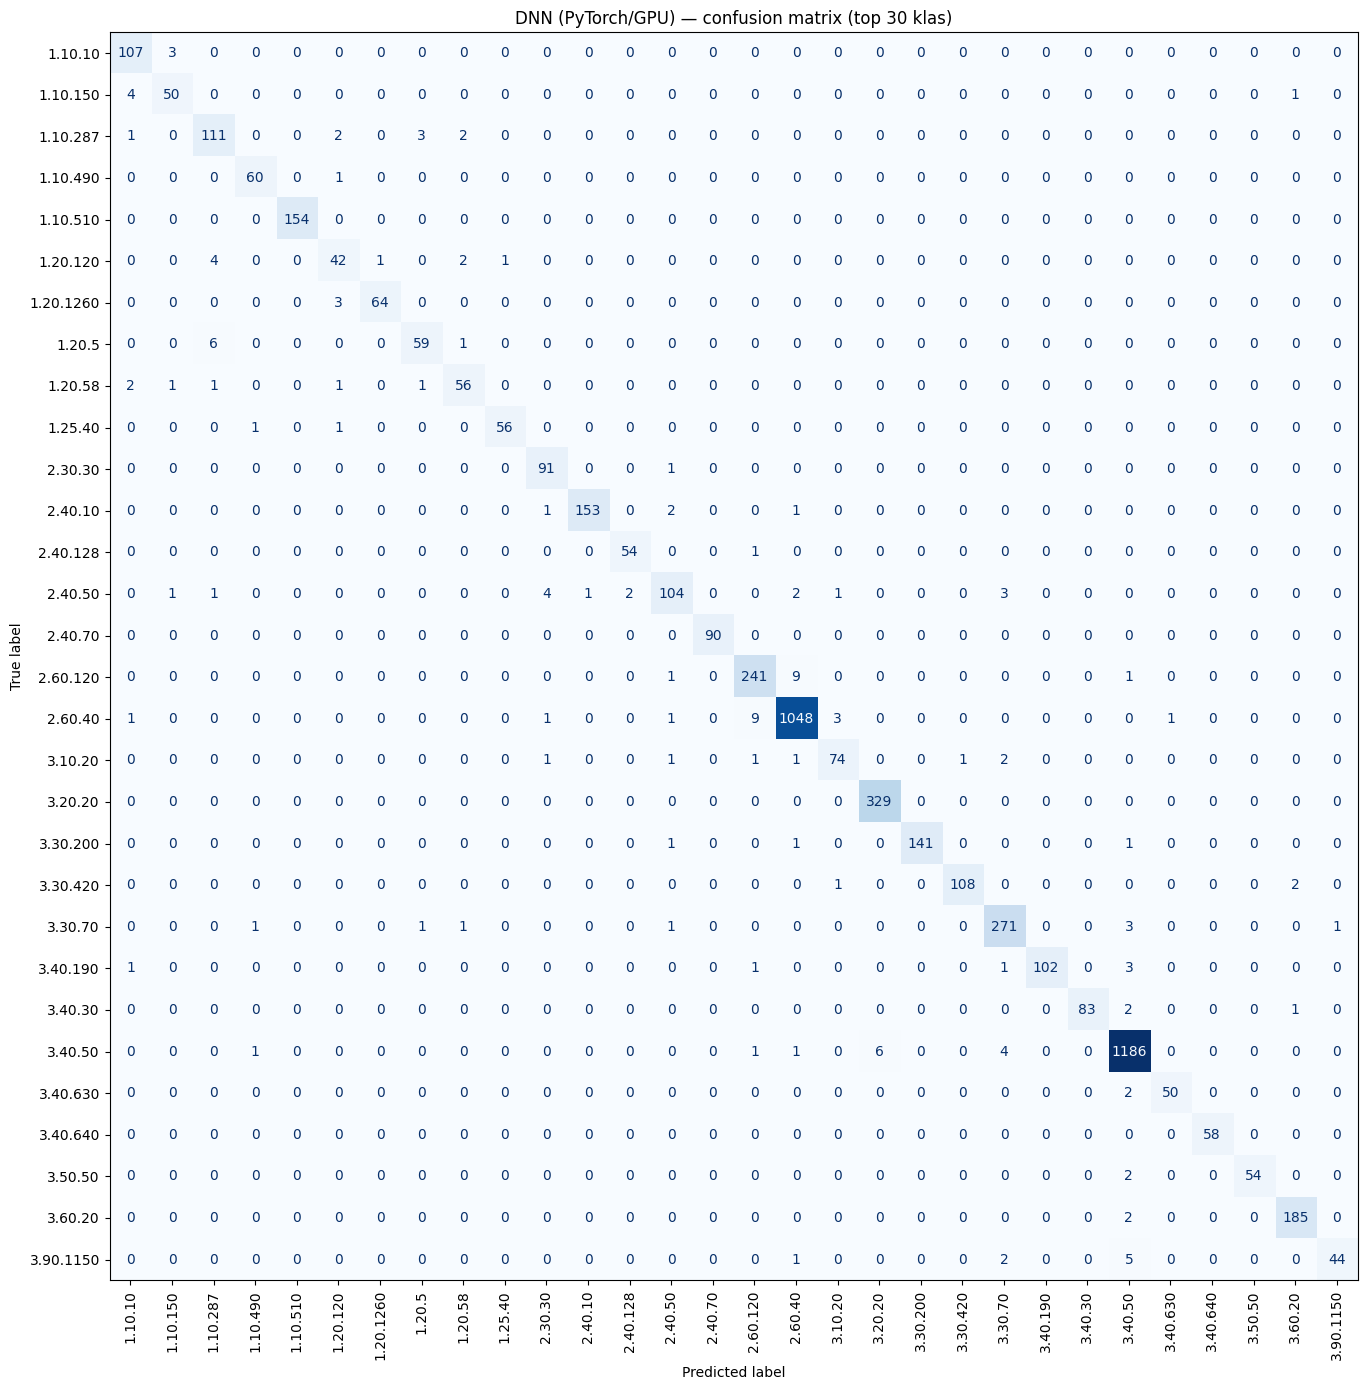


DNN (PyTorch/GPU) — metryki na poziomie C
--------------------------------------------------------------------------------
Accuracy:  97.36%
F1 macro:  89.88%
Precision: 89.11%
Recall:    90.70%
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.97      0.98      0.97      2062
           2       0.97      0.98      0.97      2620
           3       0.99      0.97      0.98      5095
           4       0.86      0.89      0.87       109
           6       0.68      0.71      0.69        73

    accuracy                           0.97      9959
   macro avg       0.89      0.91      0.90      9959
weighted avg       0.97      0.97      0.97      9959


DNN (PyTorch/GPU) (C) — TOP 10 najczęściej mylonych (true → pred)


,true_label,pred_label,count
0,3,2,82
1,3,1,41
2,2,3,37
3,1,3,25
4,6,1,18
5,1,6,17
6,3,4,9
7,2,1,5
8,4,3,4
9,1,4,4


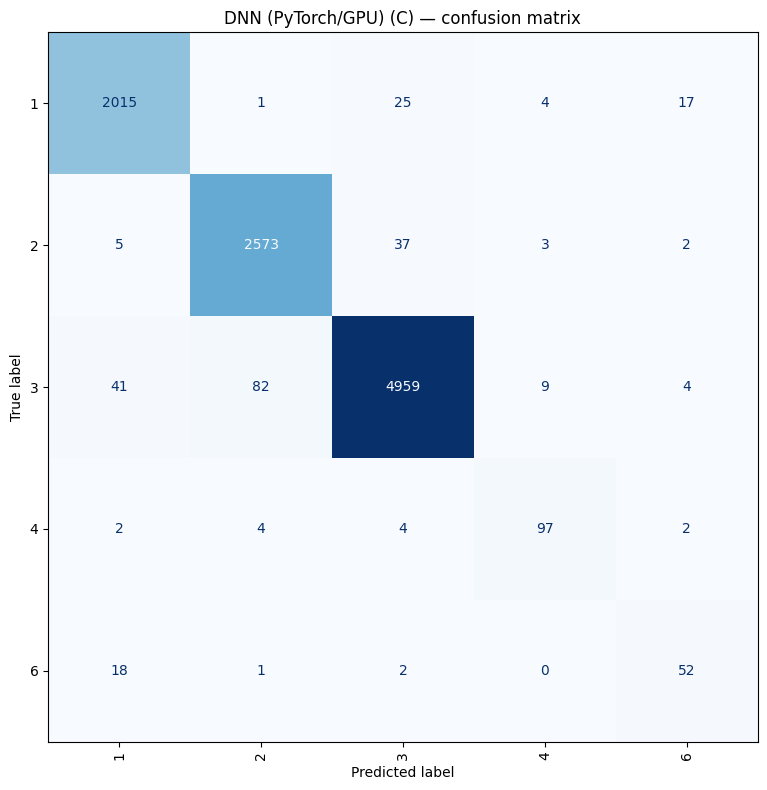


DNN (PyTorch/GPU) — metryki na poziomie C.A
--------------------------------------------------------------------------------
Accuracy:  94.12%
F1 macro:  89.69%
Precision: 90.75%
Recall:    89.29%
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

        1.10       0.94      0.95      0.94      1361
        1.20       0.90      0.91      0.91       598
        1.25       0.92      0.94      0.93        84
        1.50       0.89      0.89      0.89        19
        2.10       0.93      0.91      0.92        82
       2.100       0.86      0.86      0.86         7
       2.102       1.00      1.00      1.00         8
       2.110       1.00      1.00      1.00         1
       2.115       1.00      1.00      1.00        12
       2.120       0.92      1.00      0.96        22
       2.130       0.98      0.96      0.97        50
       2.140       1.00      1.00      1.00        11
       2.150      

,true_label,pred_label,count
0,1.20,1.10,38
1,1.10,1.20,34
2,3.30,3.40,31
3,3.40,3.30,24
4,3.90,3.30,19
5,3.30,1.10,17
6,3.10,3.30,14
7,3.90,3.40,13
8,3.30,3.10,11
9,3.30,3.90,11


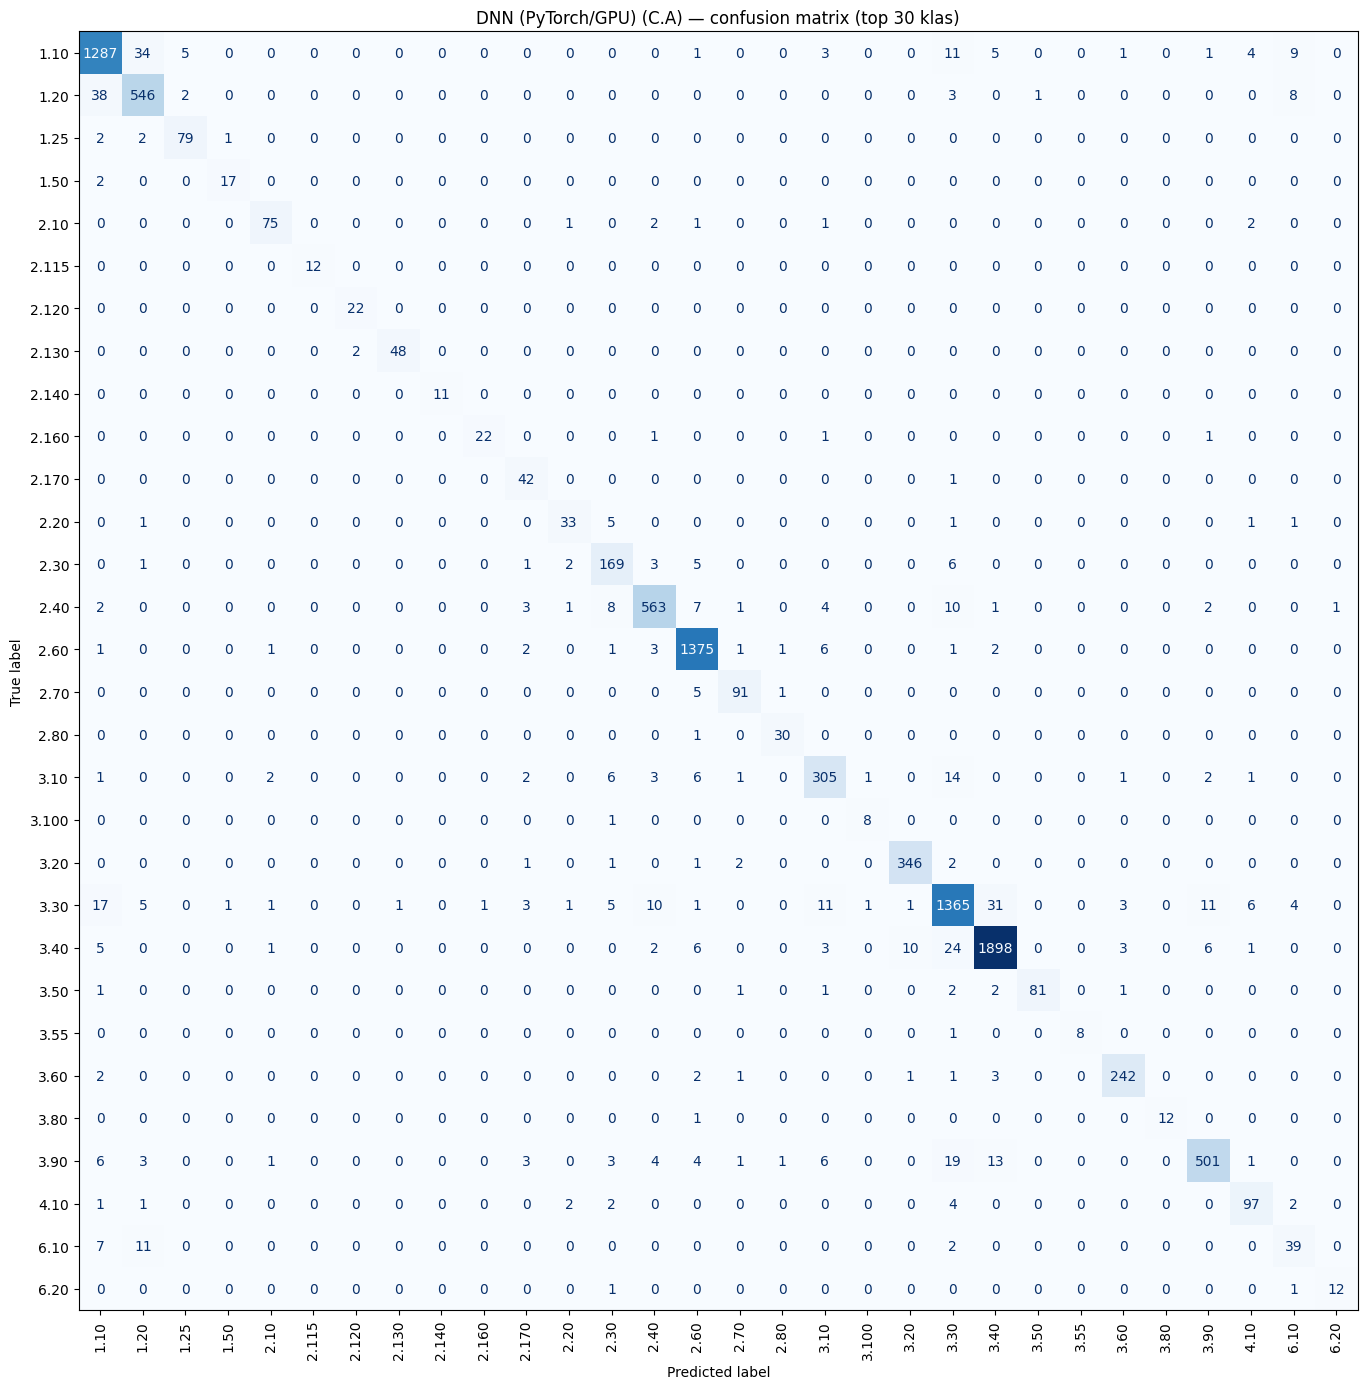


DNN (PyTorch/GPU) — metryki na poziomie C.A.T
--------------------------------------------------------------------------------
Accuracy:  91.38%
F1 macro:  78.07%
Precision: 80.82%
Recall:    77.68%
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

     1.10.10       0.76      0.89      0.82       120
    1.10.100       1.00      1.00      1.00         1
   1.10.1020       1.00      1.00      1.00         1
   1.10.1030       1.00      1.00      1.00         1
   1.10.1040       0.62      0.56      0.59         9
   1.10.1050       1.00      1.00      1.00         6
   1.10.1060       1.00      1.00      1.00         3
   1.10.1070       1.00      1.00      1.00         4
   1.10.1090       1.00      1.00      1.00         1
    1.10.110       0.00      0.00      0.00         1
   1.10.1130       0.75      1.00      0.86         3
   1.10.1140       1.00      1.00      1.00         8
   1.10.1160    

,true_label,pred_label,count
0,2.60.120,2.60.40,9
1,2.60.40,2.60.120,9
2,1.20.5,1.10.287,6
3,3.40.50,3.20.20,6
4,3.30.300,3.30.70,6
5,1.10.10,1.10.8,5
6,2.40.30,2.40.50,5
7,3.90.1150,3.40.50,5
8,1.10.150,1.10.10,4
9,6.10.140,1.20.58,4


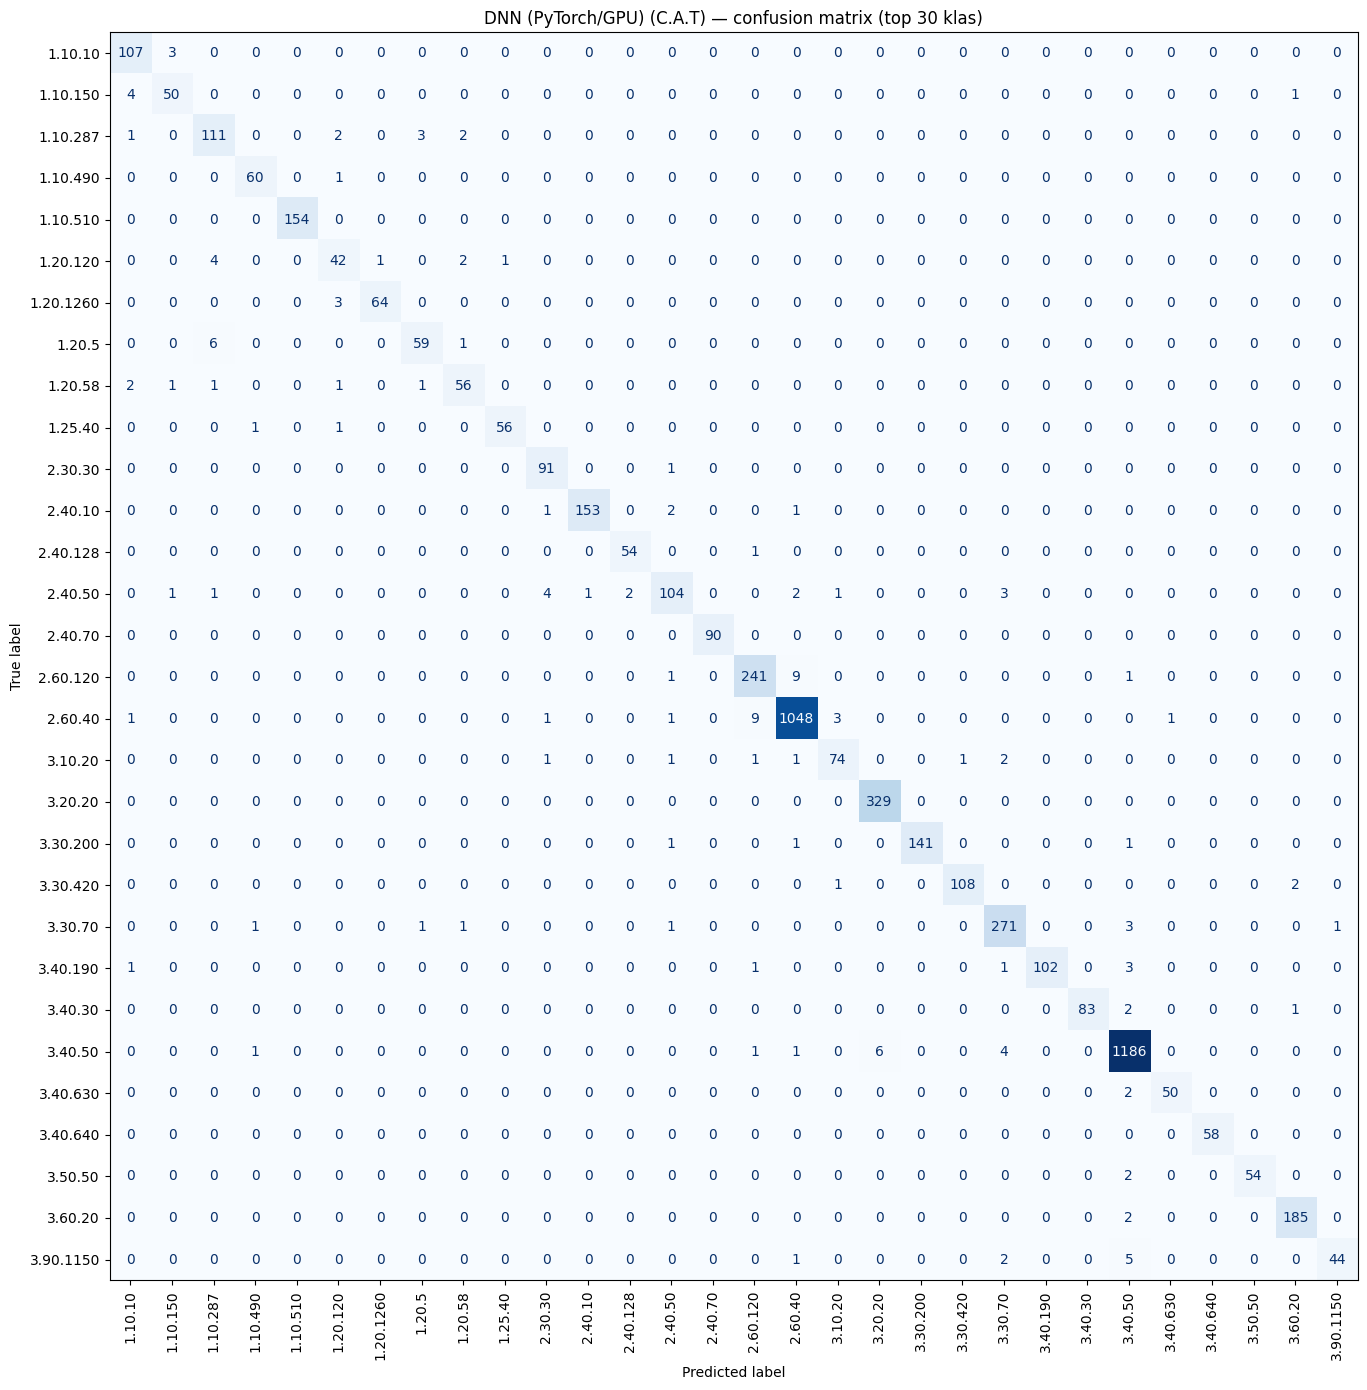

,accuracy,f1_macro,precision_macro,recall_macro
level,,,,
C,0.973592,0.898843,0.891084,0.906962
C.A,0.941159,0.896931,0.907479,0.892919
C.A.T,0.913847,0.780747,0.808190,0.776789


In [16]:

class MLPClassifier(nn.Module):
    def __init__(self, input_dim: int, num_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        return self.net(x)

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

model = MLPClassifier(input_dim=input_dim, num_classes=output_dim).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
EPOCHS = 1000

loss_history = []

for epoch in range(EPOCHS):
    model.train()

    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss_history.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

print("Ewaluacja")
model.eval()
with torch.no_grad():
    outputs = model(X_test_t)
    _, predicted = torch.max(outputs.data, 1)
    y_pred = predicted.cpu().numpy()

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
p = precision_score(y_test, y_pred, average='macro', zero_division=0)
r = recall_score(y_test, y_pred, average='macro', zero_division=0)

# Zapis metryk do porównania
results['DNN (PyTorch/GPU)'] = {
    'accuracy': acc,
    'f1_macro': f1,
    'precision_macro': p,
    'recall_macro': r,
}
globals()['results'] = results

print("-" * 30)
print(f"Accuracy:       {acc:.2%}")
print(f"F1:       {f1:.2%}")
print(f"Precision: {p:.2%}")
print(f"Recall:    {r:.2%}")
print("-" * 30)

unique_test_labels = np.unique(y_test)
target_names = le.inverse_transform(unique_test_labels)

print(classification_report(
    y_test,
    y_pred,
    labels=unique_test_labels,
    target_names=target_names,
    zero_division=0
) )

# Confusion matrix + TOP-10 pomyłek
show_confusion_and_top_mistakes(
    y_true=y_test,
    y_pred=y_pred,
    label_encoder=le,
    title='DNN (PyTorch/GPU)',
    top_k=10,
    max_classes=30,
)

# Metryki na poziomach C / C.A / C.A.T
df_levels = report_metrics_by_cath_levels(
    y_true=y_test,
    y_pred=y_pred,
    label_encoder=le,
    title='DNN (PyTorch/GPU)',
    top_k=10,
    max_classes=30,
)
results_levels = globals().get('results_levels', {})
results_levels['DNN (PyTorch/GPU)'] = df_levels
globals()['results_levels'] = results_levels
display(df_levels)

In [17]:
# Wyświetl kilka przykładowych predykcji
n_examples = 10
sample_indices = np.random.choice(len(y_test), size=min(n_examples, len(y_test)), replace=False)

print("Przykładowe predykcje:")
print("-" * 80)
print(f"{'True Label':<20} {'Predicted Label':<20} {'Correct':<10}")
print("-" * 80)

for idx in sample_indices:
    true_label = le.inverse_transform([y_test[idx]])[0]
    pred_label = le.inverse_transform([y_pred[idx]])[0]
    is_correct = "✓" if y_test[idx] == y_pred[idx] else "✗"

    print(f"{true_label:<20} {pred_label:<20} {is_correct:<10}")

print("-" * 80)

Przykładowe predykcje:
--------------------------------------------------------------------------------
True Label           Predicted Label      Correct   
--------------------------------------------------------------------------------
1.10.245             1.10.245             ✓         
3.30.420             3.30.420             ✓         
3.40.1170            3.40.1170            ✓         
3.40.50              3.40.50              ✓         
2.40.160             3.10.129             ✗         
2.40.70              2.40.70              ✓         
1.10.1780            1.10.1780            ✓         
3.60.20              3.60.20              ✓         
2.40.70              2.40.70              ✓         
2.40.20              2.40.20              ✓         
--------------------------------------------------------------------------------


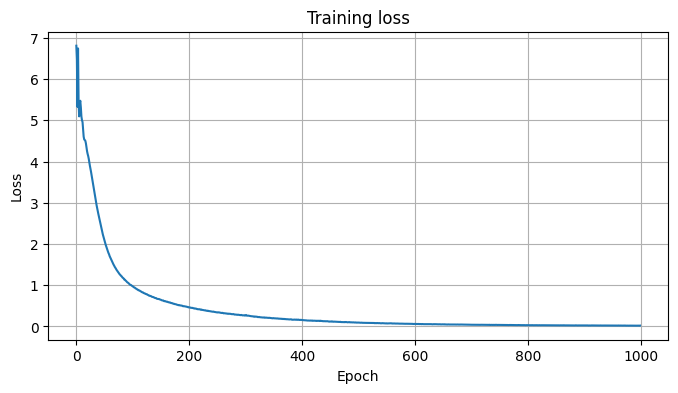

In [18]:
# Wykres loss
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.grid(True)
plt.show()

Poniżej wyświetlamy porówanie wyników obu modeli na wykresie słupkowym dla różnych metryk klasyfikacji.

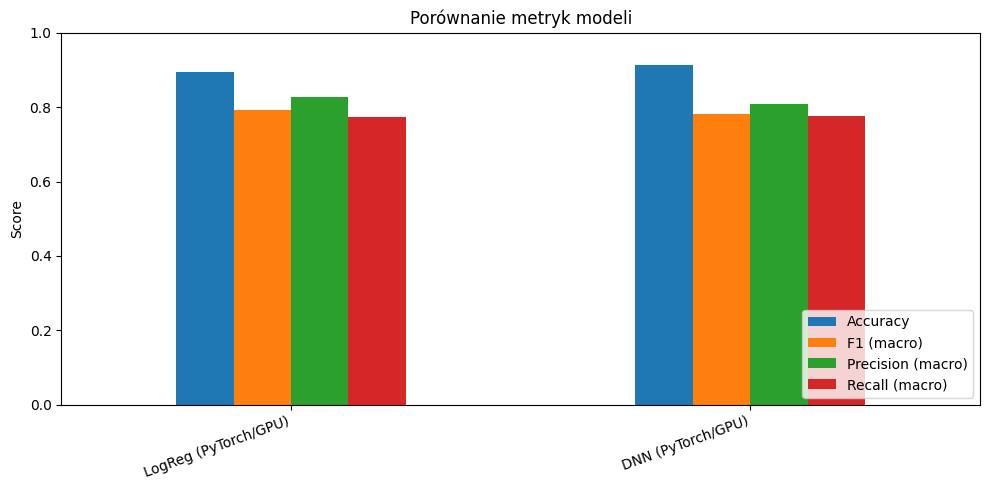

,Accuracy,F1 (macro),Precision (macro),Recall (macro)
LogReg (PyTorch/GPU),0.894869,0.791255,0.828411,0.774353
DNN (PyTorch/GPU),0.913847,0.780747,0.808190,0.776789


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

if 'results' not in globals() or not results:
    raise RuntimeError("Brak metryk w `results`. Uruchom komórki z modelami (GPU LR, DNN) i spróbuj ponownie.")

df_metrics = pd.DataFrame(results).T[['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']]
df_metrics = df_metrics.rename(columns={
    'accuracy': 'Accuracy',
    'f1_macro': 'F1 (macro)',
    'precision_macro': 'Precision (macro)',
    'recall_macro': 'Recall (macro)',
})

ax = df_metrics.plot(kind='bar', figsize=(10, 5))
ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.set_title('Porównanie metryk modeli')
ax.legend(loc='lower right')
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.show()

display(df_metrics)